In [176]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
df = pd.read_csv("train.csv", index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [178]:
df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

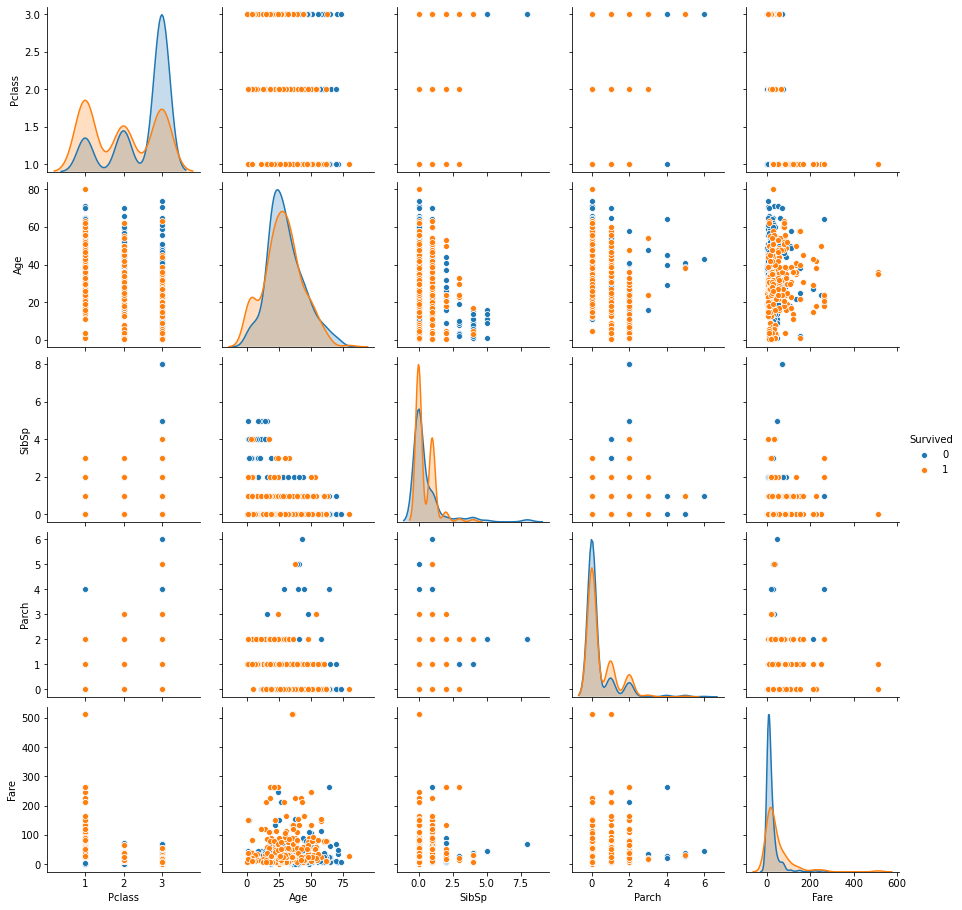

In [180]:
sns.pairplot(hue='Survived', data=df)

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

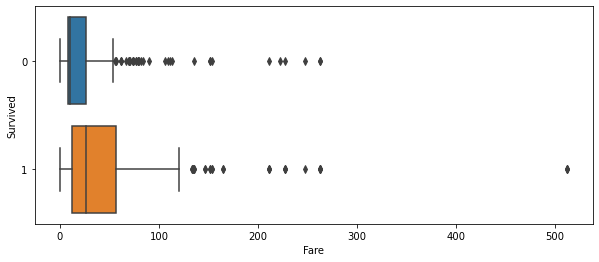

In [181]:
plt.figure(figsize=(10, 4))
sns.boxplot(y='Survived', x='Fare', orient='h', data=df)

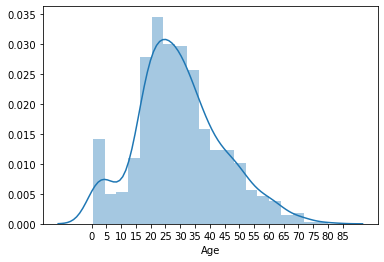

In [182]:
sns.distplot(df['Age'])
plt.xticks(np.arange(0, 90, step=5), map(str, np.arange(0, 90, step=5)))
plt.show()

### count of Survived with another params 

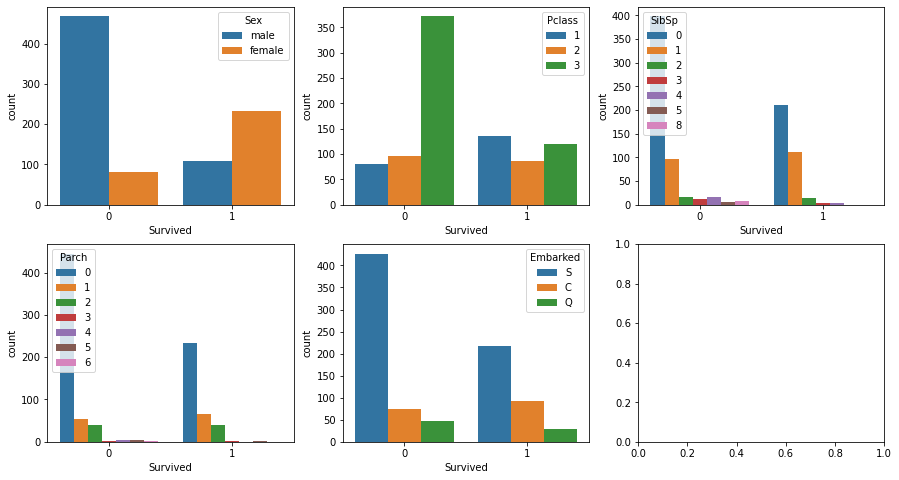

In [183]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
compare_surive_with = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
for i, hue_val in enumerate(compare_surive_with):
    sns.countplot(x='Survived', hue=hue_val, data=df, ax=axes[i//3][i%3])

In [184]:
def fill_na_values(df):
    df_filled = df.copy()
    for column in df_filled.columns:
        if df_filled[column].isna().sum() > 0:
            most_popular_value = df_filled[column].value_counts().index[0]
            df_filled[column] = df_filled[column].fillna(most_popular_value)
    return df_filled

In [185]:
df = fill_na_values(df)

In [186]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S


In [187]:
from sklearn.preprocessing import LabelBinarizer

In [188]:
def binarize_columns(df):
    df_binarized = df.copy()
    columns_drop = []
    
    for column in df.columns:
        if df[column].dtype == 'object':
            columns_drop.append(column)
            binarizer = LabelBinarizer().fit(df[column])
            binarized_data = binarizer.transform(df[column])
            if len(binarizer.classes_) > 2:
                for i, subclass in enumerate(binarizer.classes_):
                    df_binarized[f'{column}_{subclass}'] = binarized_data[:, i]
            else:
                df_binarized[f'{column}_binared'] = binarized_data.reshape(-1)
                
    df_binarized = df_binarized.drop(columns=columns_drop)
    return df_binarized 

In [189]:
df = binarize_columns(df)
df = df.astype(float)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binared,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
2,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
3,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
4,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
5,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


In [190]:
def fare_much(df, fare_percentile_value=None):
    df_fare = df.copy()
    if fare_percentile_value is None:
        fare_perc_not_survived = np.percentile(df[df['Survived']==0]['Fare'], 75)
    else:
        fare_perc_not_survived = fare_percentile_value
    df_fare['high_fare'] = (df['Fare'] > fare_perc_not_survived).astype(float)
    df_fare = df_fare.drop(columns=['Fare'])
    return df_fare, fare_perc_not_survived

In [191]:
df, fare_percentile = fare_much(df)
df.head(3)

,Survived,Pclass,Age,SibSp,Parch,Sex_binared,Embarked_C,Embarked_Q,Embarked_S,high_fare
PassengerId,,,,,,,,,,
1,0.0,3.0,22.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,1.0,38.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,3.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [192]:
def age_diapasone(df):
    df_age_diapasones = df.copy()
    diapasones = [0, 15, 35, 50]
    for step in range(len(diapasones)-1):
        df_age_diapasones[f'age_{diapasones[step]}-{diapasones[step+1]}'] = ((df_age_diapasones['Age'] >= diapasones[step]) &
                                                                             (df_age_diapasones['Age'] < diapasones[step+1])).astype(float)
    
    df_age_diapasones[f'age_higher_{diapasones[-1]}'] = (df_age_diapasones['Age'] >= diapasones[-1]).astype(float)
    df_age_diapasones = df_age_diapasones.drop(columns='Age')
    return df_age_diapasones

In [193]:
df = age_diapasone(df)
df.head()

,Survived,Pclass,SibSp,Parch,Sex_binared,Embarked_C,Embarked_Q,Embarked_S,high_fare,age_0-15,age_15-35,age_35-50,age_higher_50
PassengerId,,,,,,,,,,,,,
1,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [194]:
def is_alone(df):
    df_alone = df.copy()
    df_alone['Is_alone'] = ((df_alone['Parch'] + df_alone['SibSp']) == 0).astype(float)
    return df_alone

In [195]:
df = is_alone(df)
df.head(3)

,Survived,Pclass,SibSp,Parch,Sex_binared,Embarked_C,Embarked_Q,Embarked_S,high_fare,age_0-15,age_15-35,age_35-50,age_higher_50,Is_alone
PassengerId,,,,,,,,,,,,,,
1,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [196]:
df.to_csv('train_transformed.csv', index=False)

In [203]:
def pipeline(df_in, fare_percentile):
    df = df_in.copy()
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    df = fill_na_values(df)
    df = binarize_columns(df)
    df = df.astype(float)
    df, _ = fare_much(df, fare_percentile)
    df = age_diapasone(df)
    df = is_alone(df)
    
    return df

In [198]:
df_test = pd.read_csv("test.csv", index_col=0)

In [205]:
df_test_transformed = pipeline(df_test, fare_percentile=fare_percentile)

In [207]:
print('train shape =', df.shape, 'test shape =', df_test_transformed.shape)

train shape = (891, 14) test shape = (418, 13)


In [208]:
list(zip(df.drop(columns='Survived').columns, df_test_transformed.columns))

[('Pclass', 'Pclass'),
 ('SibSp', 'SibSp'),
 ('Parch', 'Parch'),
 ('Sex_binared', 'Sex_binared'),
 ('Embarked_C', 'Embarked_C'),
 ('Embarked_Q', 'Embarked_Q'),
 ('Embarked_S', 'Embarked_S'),
 ('high_fare', 'high_fare'),
 ('age_0-15', 'age_0-15'),
 ('age_15-35', 'age_15-35'),
 ('age_35-50', 'age_35-50'),
 ('age_higher_50', 'age_higher_50'),
 ('Is_alone', 'Is_alone')]

In [206]:
df_test_transformed.to_csv('test_transformed.csv', index=False)